# This is the 4th installment of the Federal Open Data Analytics Edge series.

### Focus on Initial Analytics using a local copy of the USAspending.gov data.

### Uses the Python Dask package to simplify processing of very large datasets that would be out-of-memory on a local machine using the standard pandas package.

In [351]:
import os, glob, pathlib
import math
import shutil
from datetime import datetime
from collections import Counter
import zipfile
import pandas as pd
import dask
import dask.dataframe as dd
from dask.distributed import Client, progress
import psutil
import requests

# speed up suggestion from here - https://stackoverflow.com/questions/51590696/speeding-up-read-csv-in-python-pandas
from multiprocessing import Pool

### See blog #3 ( https://medium.com/@lulstrup/3-automated-download-of-usaspending-gov-gfy-archives-e6c71b3eb7d1 ) in my series for instructions on downloading the data from USAspending.gov that you will need for the processing and analytics in the code below.

In [250]:
def Display_System_Info(): # https://psutil.readthedocs.io/en/latest/#psutil.virtual_memory
    physical_cores = psutil.cpu_count(logical=False) #, psutil.cpu_count(logical=True)
    RAM_total_installed = psutil.virtual_memory()[0] #, psutil.swap_memory()
    RAM_available = psutil.virtual_memory().available #['available']
    dask_workers = int(physical_cores/2)
    print(f"Physical CPU Cores: {physical_cores}, RAM available: {round(RAM_available/1e9)} GB, total RAM: {round(RAM_total_installed/1e9)} GB")
    result_record = {'CPU_Cores_Physical' : physical_cores,
                    'RAM_available' : RAM_available,
                     'RAM_total_installed' : RAM_total_installed,
                    }
    return result_record

Display_System_Info()

Physical CPU Cores: 8, RAM available: 24 GB, total RAM: 69 GB


{'CPU_Cores_Physical': 8,
 'RAM_available': 24492806144,
 'RAM_total_installed': 68719476736}

In [251]:
def Get_Current_Time():
    return datetime.now().strftime("%d/%m/%Y %H:%M:%S")

Get_Current_Time()

'24/09/2020 11:02:30'

In [252]:
# this assumes the jupyter notebook is running in the same higher level directory
# where the USAspending.gov zip archives and the decompressed Zip files are stored

original_cwd = os.getcwd()
download_file_path = os.path.join(original_cwd, "USAspending_Archive_Downloads") #
download_file_path_CSV = os.path.join(original_cwd, "USAspending_Archive_Downloads", "Expanded_CSV_Files")

your_path_dummy = 'Users/YourName/YourTopFolder_Documents/YourUSAspendingFolderName'
#print(original_cwd)
print(os.path.join(your_path_dummy, os.path.basename(download_file_path)))
print(os.path.join(os.path.join(your_path_dummy, os.path.basename(download_file_path)), os.path.basename(download_file_path_CSV)))

Users/YourName/YourTopFolder_Documents/YourUSAspendingFolderName/USAspending_Archive_Downloads
Users/YourName/YourTopFolder_Documents/YourUSAspendingFolderName/USAspending_Archive_Downloads/Expanded_CSV_Files


In [253]:
def CurrentGFY():
    if datetime.now().month >= 10: 
        return datetime.now().year + 1
    else:
        return datetime.now().year
    
def Check_Archive_Filename_Format(filename_complete):
    base_filename = os.path.basename(filename_complete)
    # rule checks
    if not base_filename.startswith("FY"):
        return False
    if not base_filename.endswith(".zip") and not base_filename.endswith(".csv"):
        return False
    if " " in base_filename:
        return False
    if len(base_filename.split(".")) > 2:
        return False
    if "copy" in base_filename:
        return False
    
    return True

def Get_GFY_from_file_path(filename_to_check_complete_path):
    if os.path.isdir(filename_to_check_complete_path):
        #print(f"{filename_to_check_complete_path} is a directory. Ignore")
        return
    filename_GFY = os.path.basename(filename_to_check_complete_path)[:6]
    assert filename_GFY[:2] == 'FY' # check this
    return filename_GFY

def Get_ArchiveDate_from_file_path(filename_to_check_complete_path):
    if os.path.isdir(filename_to_check_complete_path):
        #print(f"{filename_to_check_complete_path} is a directory. Ignore")
        return
    basefilename = os.path.basename(filename_to_check_complete_path)
    if filename_to_check_complete_path.endswith(".zip"):
        filename_latest_update = basefilename.split("_")[4][0:8]
    elif filename_to_check_complete_path.endswith(".csv"):
        filename_latest_update = basefilename.split("_")[4][0:8]
    else:
        filename_latest_update ="Filename_Format_Issue"
    # assert TBD
    return filename_latest_update

In [355]:
# Clean up the Data and add some fields

### function to create a recipient common name using common fields
### addresses problem with multiple versions of names, M&A, and misspellings

#### Please read this link on the USAspending.gov site about use of "D&B Open Data" - https://www.usaspending.gov/db_info
#### "D&B Open Data" is embedded in these records

#TODO - placeholder function - enhance this to find the most common name for the same company in the records 
def Add_Common_Recipient_Names(df): #placeholder for future data validation using a common key(s) or hash value
    # add transformation and validation code to select most common name for an entity-firm-contractor
    df['recipient_parent_name_common'] = df['recipient_parent_name']
    df['recipient_name_common'] = df['recipient_name']
    return df

# !!! possible use in the future cage_codes are missing for most records prior to GFY19
# def Add_Common_Recipient_Names_Using_CAGE_Code(df): #works ok starting in FY19 (missing from ~200M $s in GFY19) but is unreliable prior to that - missing
#     # Build cage_code to recipient_parent_name, recipient_name mapping and collect the most common names
#     # There are naming inconsistencies in the USAspending.gov data for recipient_names
#     # Create code to build a unique identifier that can be used in groupby for recipient_parent_name when there are spelling and naming inconsistencies

#     cage_name_mapping = df[['action_date_fiscal_year','cage_code','recipient_parent_name', 'recipient_name']].drop_duplicates()
#     #cage_name_mapping.shape

#     #TODO add code to properyly handle how the recipient_parent_name and the recipient_name may change across GFY
#     # get the most common recipient_name for each cage_code
#     cage_name_mapping_recipient_parent = cage_name_mapping.groupby(['cage_code'])['recipient_parent_name'].apply(list).apply(Counter).apply(lambda x: x.most_common()[0][0])
#     cage_name_mapping_recipient = cage_name_mapping.groupby(['cage_code'])['recipient_name'].apply(list).apply(Counter).apply(lambda x: x.most_common()[0][0])

#     #cage_name_mapping_recipient_parent['00026'] # assert in FY2019 == 'MMC INTERNATIONAL CORP.'

#     # add a column with the most common recipient_name for downstream groupby actions
#     df['recipient_parent_name_common'] = df['cage_code'].apply(lambda x: cage_name_mapping_recipient_parent[x])
#     df['recipient_name_common'] = df['cage_code'].apply(lambda x: cage_name_mapping_recipient[x])    
#     return df

def Fix_Recipient_Name_UNSPECIFIED(df):
    #fix blank or UNSPECIFIED recipient_parent_names
    
#     fix_UNSPECIFIED_lambda = lambda x: x['recipient_name'] + "_UNSPECIFIED" if x['recipient_parent_name'] in ['', 'UNSPECIFIED'] else x['recipient_parent_name']
#     #pandas.core.frame.DataFrame, dask.dataframe.core.DataFrame
#     if type(df) == dask.dataframe.core.DataFrame:
#         df['recipient_parent_name'] = df.apply(fix_UNSPECIFIED_lambda, axis = 1, meta=('recipient_parent_name', 'object'))
#     else:
#         df['recipient_parent_name'] = df.apply(fix_UNSPECIFIED_lambda, axis = 1)
    
    df['recipient_parent_name'] = df['recipient_parent_name'].mask(df['recipient_parent_name'] == 'UNSPECIFIED', df['recipient_parent_name'] + "_UNSPECIFIED") # use of mask instead of other options - https://docs.dask.org/en/latest/dataframe-api.html#dask.dataframe.DataFrame.mask

    return df

def Fix_Recipient_Names_Known_Issues(df): # MANUAL Fixes needed due to USAspending.gov not updating recipient_parent_name (e.g., after SAIC spun out Leidos)
    #TODO - shoould be added at time of read of the files as part of prep
    
    #fix Naming Issues - Manual Fixes (large firms mostly - edit the external files)
    
    if glob.glob("USAspending_Parent_Name_Fixes_Manual.csv"):
        df_fixes = pd.read_csv("USAspending_Parent_Name_Fixes_Manual.csv")
        manual_fixes_lookup = {}
        for index, row in df_fixes.iterrows():
            manual_fixes_lookup[row['recipient_old_name']] = {'recipient_new_name' :row['recipient_new_name'],
                                                              'GFY_When_Switch_Happens' : row['GFY_When_Switch_Happens'],
                                                             }
    
    else:
        manual_fixes_lookup = {
            'SCIENCE APPLICATIONS INTERNATIONAL CORPORATION' : {'recipient_new_name' : 'LEIDOS HOLDINGS  INC.',
                                                               'GFY_When_Switch_Happens' : '2014'}, #!!Notes ther is an extra space needed between HOLDINGS and Inc. name in USAspending, common name fix
            'NORTHROP GRUMMAN SYSTEMS CORPORATION' : {'recipient_new_name' : 'NORTHROP GRUMMAN CORPORATION',
                                                      'GFY_When_Switch_Happens' : ''
                                                     },

        }
    
    for old_name, new_name_record in manual_fixes_lookup.items():
        new_name = new_name_record['recipient_new_name']
        GFY_When_Switch_Happens = new_name_record['GFY_When_Switch_Happens']
        # mask preferred via https://stackoverflow.com/questions/54360549/dask-item-assignment-cannot-use-loc-for-item-assignment
        
        if not math.isnan(GFY_When_Switch_Happens) and GFY_When_Switch_Happens != '':
            selector = (df['recipient_parent_name'] == old_name) & (df['action_date_fiscal_year'].astype('int64') >= int(GFY_When_Switch_Happens))
        else:
            selector = (df['recipient_parent_name'] == old_name)
        
        df['recipient_parent_name'] = df['recipient_parent_name'].mask(selector, new_name) # use of mask instead of other options - https://docs.dask.org/en/latest/dataframe-api.html#dask.dataframe.DataFrame.mask
        
    return df

def Enhance_Spending_File(df): # this function addresses known shortcomings in the USAspending archive data
    print()
    print(f"{Get_Current_Time()} -> replacing NaN with UNSPECIFIED...")
    df = df.fillna("UNSPECIFIED") # IMPORTANT - NA fields can affect groupby sums and other problems
    print(f"{Get_Current_Time()} -> adding PSC_Cat field...")
    df['PSC_Cat'] = df['product_or_service_code'].str[:1]
    df['PSC_Cat_2'] = df['product_or_service_code'].str[:2]
    print(f"{Get_Current_Time()} -> fixing missing recipient_parent_name...")
    df = Fix_Recipient_Name_UNSPECIFIED(df)
    print(f"{Get_Current_Time()} -> fixing recipient_parent_names that are inconsistent...")
    df = Fix_Recipient_Names_Known_Issues(df)
    print(f"{Get_Current_Time()} -> adding recipient_name_common and recipient_parent_name_common fields for groupby")
    df = Add_Common_Recipient_Names(df)
    print(f"{Get_Current_Time()} Done with fixes.")
    print()
    return df

In [364]:
# ##TEST Fix_Recipient)Names_Known

# gfy_filename_prefix = 'FY2019'
# filename_list_subset = [filename for filename in csv_files_list if os.path.basename(filename).startswith(gfy_filename_prefix)]

# df_subset_test = Load_CSV_Files_Into_DF([filename_list_subset[0]]) #load one file with [filename_list_subset[0]] vs all files with filename_list_subset
# #df_subset_test = Enhance_Spending_File(df_subset)

# df_subset_test[df_subset_test['recipient_parent_name'] == 'SCIENCE APPLICATIONS INTERNATIONAL CORPORATION']

# %%time
# df_subset_test_fixed = Fix_Recipient_Names_Known_Issues(df_subset_test.copy())
# df_subset_test_fixed[df_subset_test_fixed['recipient_parent_name'] == 'SCIENCE APPLICATIONS INTERNATIONAL CORPORATION']

# df_subset_test[df_subset_test['recipient_parent_name']=='LEIDOS HOLDINGS  INC.'].shape, df_subset_test_fixed[df_subset_test_fixed['recipient_parent_name']=='LEIDOS HOLDINGS  INC.'].shape

# df_subset_test_fixed[df_subset_test_fixed['recipient_parent_name'] == 'NORTHROP GRUMMAN SYSTEMS CORPORATION']

In [255]:
## Key code for read CSV files into pandas and Dask
def Build_DTypes_Dict(filename_list):
    df = pd.read_csv(filename_list[0], nrows=1)
    
    dtype = dict(zip(sorted(df.columns), ['object'] * len(df.columns)))
    
    # ! important - may need to change other fields to category, int, date etc for better memory management
    dtype['federal_action_obligation'] = 'float64'
    #dtype['action_date_fiscal_year'] = 'int'
    
    return dtype

def Load_CSV_Files_Into_DF(filename_list): #best approach if you have enough RAM memory on your machine
    
    dtype = Build_DTypes_Dict(filename_list) # ! important - may need to change other fields to category, int, date etc for better memory management
    
#     print(f"Reading file: {filename_list[0]}")
#     df = pd.read_csv(filename_list[0], dtype=dtype, low_memory=False) # read the first file
    
#     for filename in filename_list[1:]: #read the remaining files and append
#         print(f"Reading file: {filename}")
#         df = df.append(pd.read_csv(filename, dtype=dtype, low_memory=False))
        
    #alternative approach - faster?
    dataframe_loads_list = []
    for filename in filename_list:
        print(f"Reading file: {os.path.basename(filename)}")
        dataframe_loads_list.append(pd.read_csv(filename, dtype=dtype, low_memory=False))
    df = pd.concat(dataframe_loads_list)
    print("Files loaded into pandas dataframe.")
    return df

def parallel_pandas_read_csv(filename):
    dtype = Build_DTypes_Dict([filename]) #Build_DTypes_Dict expects a list so wrap this
    'converts a filename to a pandas dataframe'
    return pd.read_csv(filename, dtype=dtype, low_memory=False)

def Load_CSV_Files_Into_DF_Parallel(filename_list):
    dtype = Build_DTypes_Dict(filename_list)
    # set up your pool
    physical_cores = psutil.cpu_count(logical=False)
    pool = Pool(processes=physical_cores) # or whatever your hardware can support

    # have your pool map the file names to dataframes
    df_list = pool.map(parallel_pandas_read_csv, filename_list)

    # reduce the list of dataframes to a single dataframe
    combined_df = pd.concat(df_list, ignore_index=True)
    return combined_df

### Collect the available USAspending.gov GFY archive files

In [256]:
# do a quick check to make sure the CSV files are there
csv_files_list = sorted(glob.glob(os.path.join(download_file_path_CSV, "*.csv")))

gfy_list = set()
size_of_files_GB = 0
for n, filename in enumerate(csv_files_list):
    filename_basename = os.path.basename(filename)
    print(n+1, filename_basename)
    gfy_list.add(filename_basename[:6])
    size_of_files_GB += os.path.getsize(filename)

all_GFY_list = sorted(set([Get_GFY_from_file_path(filename) for filename in csv_files_list]))
    
print()
print(f"There are {len(csv_files_list)} CSV files. They use {round(size_of_files_GB/1e9, 3)} GB of storage.")
print(f"Covering GFY: {sorted(gfy_list)}")
print(f"Current GFY: {'FY' + str(CurrentGFY())}")
print()

1 FY2017_All_Contracts_Full_20200808_1.csv
2 FY2017_All_Contracts_Full_20200808_2.csv
3 FY2017_All_Contracts_Full_20200808_3.csv
4 FY2017_All_Contracts_Full_20200808_4.csv
5 FY2017_All_Contracts_Full_20200808_5.csv
6 FY2018_All_Contracts_Full_20200808_1.csv
7 FY2018_All_Contracts_Full_20200808_2.csv
8 FY2018_All_Contracts_Full_20200808_3.csv
9 FY2018_All_Contracts_Full_20200808_4.csv
10 FY2018_All_Contracts_Full_20200808_5.csv
11 FY2018_All_Contracts_Full_20200808_6.csv
12 FY2019_All_Contracts_Full_20200808_1.csv
13 FY2019_All_Contracts_Full_20200808_2.csv
14 FY2019_All_Contracts_Full_20200808_3.csv
15 FY2019_All_Contracts_Full_20200808_4.csv
16 FY2019_All_Contracts_Full_20200808_5.csv
17 FY2019_All_Contracts_Full_20200808_6.csv
18 FY2019_All_Contracts_Full_20200808_7.csv
19 FY2020_All_Contracts_Full_20200808_1.csv
20 FY2020_All_Contracts_Full_20200808_2.csv
21 FY2020_All_Contracts_Full_20200808_3.csv
22 FY2020_All_Contracts_Full_20200808_4.csv
23 FY2020_All_Contracts_Full_20200808_5.c

#### Each FY*.csv USAspending archive file has 1M records (usually in the sequence of the transaction date)

### To speed processing for Dask, you can exclude GFY that you don't need and the necessity to read those CSV files.

In [257]:
# You can limit the selection to a subset of the GFY to speed processing

ALL_GFY = False # switch to True to override the subset

user_select_GFY = ['FY2019', 'FY2018', 'FY2017']

if ALL_GFY:
    user_select_GFY = all_GFY_list
    
# print(f"GFY to read for analysis: {sorted(user_select_GFY)}")
# print()

# Create csv_files_list_restricted to streamline downstream data processing

csv_files_list = sorted(glob.glob(os.path.join(download_file_path_CSV, "*.csv")))
csv_files_list_restricted = [filename for filename in csv_files_list for GFY in user_select_GFY if GFY in filename]
gfy_found_in_files = [Get_GFY_from_file_path(filename) for filename in csv_files_list_restricted]
csv_GFY_missing = sorted(set(user_select_GFY) - set(gfy_found_in_files))

assert set(user_select_GFY) == set(user_select_GFY) # check to make sure this is working

print(f"You have selected these GFY for analysis:{user_select_GFY}")
print(f"Missing GFY: {csv_GFY_missing} -> if GFY missing, confirm you have decompressed the GFY zip file archive")

#[(os.path.basename(filename), round(os.path.getsize(filename)/1e9, 3)) for filename in csv_files_list_restricted]

You have selected these GFY for analysis:['FY2019', 'FY2018', 'FY2017']
Missing GFY: [] -> if GFY missing, confirm you have decompressed the GFY zip file archive


In [258]:
# if you have a machine with enough RAM, you are better off using pandas
# if not, you can used Dask - https://docs.dask.org/en/latest/install.html
# presentations on Dask - https://docs.dask.org/en/latest/presentations.html
# we will do both in our example

#take advantage of Dask's ability to work in parallel on the local machine
# single machine https://docs.dask.org/en/latest/setup/single-distributed.html
# Advanced - a cluster of machines with a central location for your files - https://distributed.dask.org/en/latest/quickstart.html
#client = Client(n_workers=4, threads_per_worker=4, memory_limit='4GB')

# a Dask Tutorial can be found here: https://github.com/dask/dask-tutorial
# a Dask Tutorial on using DataFrames and loading data here: https://tutorial.dask.org/04_dataframe.html

# if you have multiple machine on your network and can set up a common network location for the CSV files, 
# you can run Dask on those machine and take advantage of the full power of Dask
# you can set up a simple http file server on a local network and use that (see caution https://docs.dask.org/en/latest/remote-data-services.html#http-s)
# the node http-server is a great option for a local home network - https://www.npmjs.com/package/http-server
# 
# Dask can be deployed in the cloud also - https://docs.dask.org/en/latest/setup/cloud.html
# the data that Dask is reading can also be on a cloud based source as well such as an AWS S3 bucket, Azure, or Google cloud
# https://docs.dask.org/en/latest/remote-data-services.html
# https://s3fs.readthedocs.io/en/latest/

In [259]:
def Close_Dask_Client_Robust():
    global client
    try:
        client
    except NameError:
        client = None

    if client:
        client.close() # you can use this command to close the Dask processes and then repeat the command above to launch it again

global client

Close_Dask_Client_Robust()

dask_workers = int(psutil.cpu_count(logical=False)/2) # use half of the available cores to be safe
client = Client(n_workers=dask_workers) # if you have an NVIDIA card and CUDA installed you can take advantage of that here

client # open the Dashboard link in a separate browser window that you can observe during the computations

Client Scheduler: tcp://127.0.0.1:51636 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 16 Memory: 68.72 GB


## Begin Reading the Data into Dask

In [260]:
%%time
# Dask uses pandas but operates in a 'lazy' mode by constructing a graph of operations to perform
# unlike pandas which immediately processes the data in memory, Dask requires you to add a '.compute()'
# to specify that you want to compute the values at that point. Dask then begins processing the files on disk.

dtype = Build_DTypes_Dict(csv_files_list_restricted) # this handles reduces ambiguity for dask interpreting data type to infer on read

# for pandas DataFrames it is typical to see df and for Dask DataFrames ddf
# note that dask operates above the pandas level and depends on pandas making it easy to 
#    convert ddf files into pandas df if there is enough memory on your machine
# Working with pandas df in memory is super fast and ideal.
# If you can reduce the data to a smaller set that fits in RAM, you should do that early and use pandas for analysis
# See https://docs.dask.org/en/latest/best-practices.html for more advice on streamlining your computations
# here is a great overview of the advantages of Dask (vs PySpark) - https://www.youtube.com/watch?v=tx7qTHSlHKw presentation by https://www.linkedin.com/in/vaibhavs10/?originalSubdomain=in of Deloitte


ddf = dd.read_csv(csv_files_list_restricted, dtype=dtype) #!!! note the .compute() which executes the task in a distributed way. If it fits in memory it will operate as a pandas dataframe.

# Clean up the Data and add some fields
ddf = Enhance_Spending_File(ddf)

ddf.head()


24/09/2020 11:02:40 -> replacing NaN with UNSPECIFIED...
24/09/2020 11:02:40 -> adding PSC_Cat field...
24/09/2020 11:02:40 -> fixing missing recipient_parent_name...
24/09/2020 11:02:40 -> fixing recipient_parent_names that are inconsistent...
24/09/2020 11:02:40 -> adding recipient_name_common and recipient_parent_name_common fields for groupby
24/09/2020 11:02:40 Done with fixes.

CPU times: user 5.77 s, sys: 150 ms, total: 5.92 s
Wall time: 9.14 s


,contract_transaction_unique_key,contract_award_unique_key,award_id_piid,modification_number,transaction_number,parent_award_agency_id,parent_award_agency_name,parent_award_id_piid,parent_award_modification_number,federal_action_obligation,...,highly_compensated_officer_4_name,highly_compensated_officer_4_amount,highly_compensated_officer_5_name,highly_compensated_officer_5_amount,usaspending_permalink,last_modified_date,PSC_Cat,PSC_Cat_2,recipient_parent_name_common,recipient_name_common
0,9700_9700_1226_0_SPE5EY15D0564_0,CONT_AWD_1226_9700_SPE5EY15D0564_9700,1226,0,0,9700,DEPT OF DEFENSE,SPE5EY15D0564,ARZ998,1606.32,...,UNSPECIFIED,UNSPECIFIED,UNSPECIFIED,UNSPECIFIED,https://www.usaspending.gov/#/award/CONT_AWD_1...,2020-08-01 12:59:04,5,53,HERNDON PRODUCTS LLC,"HERNDON PRODUCTS, LLC"
1,3600_4730_VA24617F1762_0_GS07F0636W_0,CONT_AWD_VA24617F1762_3600_GS07F0636W_4730,VA24617F1762,0,0,4730,FEDERAL ACQUISITION SERVICE,GS07F0636W,PA0051ADDRESSCHG,4345.97,...,UNSPECIFIED,UNSPECIFIED,UNSPECIFIED,UNSPECIFIED,https://www.usaspending.gov/#/award/CONT_AWD_V...,2020-07-28 12:08:40,6,66,FRANKLIN YOUNG INTERNATIONAL INCORPORATED,"FRANKLIN YOUNG INTERNATIONAL, INCORPORATED"
2,9700_9700_EH10_48_N0017804D4066_1,CONT_AWD_EH10_9700_N0017804D4066_9700,EH10,48,1,9700,DEPT OF DEFENSE,N0017804D4066,0,56858.00,...,UNSPECIFIED,UNSPECIFIED,UNSPECIFIED,UNSPECIFIED,https://www.usaspending.gov/#/award/CONT_AWD_E...,2018-09-29 10:53:34,R,R4,ALION SCIENCE AND TECHNOLOGY CORPORATION,ALION - IPS CORPORATION
3,1435_4732_INM17PD00016_0_GS00Q13NSA3000_0,CONT_AWD_INM17PD00016_1435_GS00Q13NSA3000_4732,INM17PD00016,0,0,4732,FEDERAL ACQUISITION SERVICE,GS00Q13NSA3000,P00011,25714.63,...,UNSPECIFIED,UNSPECIFIED,UNSPECIFIED,UNSPECIFIED,https://www.usaspending.gov/#/award/CONT_AWD_I...,2018-11-09 15:44:21,D,D3,AT&T INC.,AT&T MOBILITY LLC
4,9700_4735_HC101315FB677_3_GS00T07NSD0040_0,CONT_AWD_HC101315FB677_9700_GS00T07NSD0040_4735,HC101315FB677,3,0,4735,FEDERAL ACQUISITION SERVICE,GS00T07NSD0040,0,6732.70,...,UNSPECIFIED,UNSPECIFIED,UNSPECIFIED,UNSPECIFIED,https://www.usaspending.gov/#/award/CONT_AWD_H...,2017-06-16 08:30:01,D,D3,CENTURYTEL INC,QWEST SERVICES CORPORATION


In [261]:
#### Please read this link on the USAspending.gov site about use of "D&B Open Data" - https://www.usaspending.gov/db_info
#### "D&B Open Data" is embedded in these records

In [262]:
# organize the 284 columns into some common topics for easy of access
date_fields = [col for col in sorted(ddf.columns) if 'date' in col]
recipient_fields = [col for col in sorted(ddf.columns) if 'recipient' in col]
agency_fields = [col for col in sorted(ddf.columns) if 'agency' in col]
code_fields = [col for col in sorted(ddf.columns) if 'code' in col]
type_fields = [col for col in sorted(ddf.columns) if 'type' in col]
obligation_fields = [col for col in sorted(ddf.columns) if 'obligation' in col]
name_fields = [col for col in sorted(ddf.columns) if 'name' in col]

print(f"Example of obligation_fields: {obligation_fields}")

Example of obligation_fields: ['federal_action_obligation']


### If you launch Dask computations but want to stop it, select the square jupyter button "interrupt the kernel"

In [263]:
##This can be used as a QC check to make sure the GFY requested were read
##this is a slow computation since Dask must read every record in all of the files
# action_date_fiscal_yearS = set(sorted(ddf['action_date_fiscal_year'].unique()))
# assert action_date_fiscal_yearS == user_select_GFY

In [264]:
# Without the command .compute() at the end of the next statement, Dask adds the task to a graph of operations.
# when Dask encounters a .compute(), the preceding graph operations are performed

df_GFY_obligations = ddf.groupby(['action_date_fiscal_year'])['federal_action_obligation'].sum().compute().reset_index()

# You can check the computations against these articles:
# https://about.bgov.com/news/federal-contract-spending-five-trends-in-five-charts/
df_GFY_obligations

,action_date_fiscal_year,federal_action_obligation
0,2017,5.105917e+11
1,2018,5.553379e+11
2,2019,5.895573e+11


In [265]:
#compute a total w/o de-obligation amounts
#ddf[ddf['federal_action_obligation'] > 0.0].groupby(['action_date_fiscal_year'])['federal_action_obligation'].sum().compute() #!!! dask requires explicit .compute() whereas pandas does not

### Another helper function to simplify subsequent processing

In [266]:
### Create a helper function to simplify some common groupby obligations reports.
def Create_Obligations_DF(df, groupby_fields = ['recipient_parent_name'], options = {'ascending' : False, 'extended_fields' : True, 'positive_obligations_only' : True}):
    
    #if 'action_date_fiscal_year' is not in groupby_fields, add it
    groupby_fields.append('action_date_fiscal_year')
    groupby_fields = sorted(set(groupby_fields))
    
    # test 'recipient_parent_name_common' assumes a pre-processing step after data is loaded to add the two recipient_name_fields fields
    # use 'recipient_parent_name_common' to groupby companies more reliably than 'recipient_parent_name'
    if 'recipient_parent_name_common' in df.columns: # if common names exist change field sort recipient name source
        groupby_fields = [column if column != 'recipient_parent_name' else 'recipient_parent_name_common' for column in groupby_fields]
        groupby_fields = [column if column != 'recipient_name' else 'recipient_name_common' for column in groupby_fields]
    else:
        print("Warning [in function Create_Obligations_DF]: In computing groupby recipient_name and recipient_parent_name is missing 'recipient_parent_name' column")
        print("...groupby totals by recipient_parent_name and recipient_name may be incomplete.")
        print("...Recommend running function Add_Common_Recipient_Names on DataFrame prior to using this function.")
    
    df_new = df.groupby(groupby_fields)['federal_action_obligation'].sum().reset_index().sort_values(by=['action_date_fiscal_year','federal_action_obligation'], ascending=[False, False]).reset_index()
    
    # remove the old index field
    df_new_columns_limited = [column_name for column_name in df_new.columns if column_name != 'index']
    df_new = df_new[df_new_columns_limited]
    
    df_new['GFY_Total_Obligations'] = 0.0
    
    if options['extended_fields']:
        df_new_GFY_totals = df_new.groupby(['action_date_fiscal_year'])['federal_action_obligation'].sum()
        for GFY, GFY_Total_Obligations in df_new_GFY_totals.items():
            df_new.loc[df_new['action_date_fiscal_year'] == GFY, 'GFY_Total_Obligations'] = GFY_Total_Obligations

##TODO confirm this is working properly
#             # use field options['positive_obligations_only']
#             if options['positive_obligations_only']:
        
        df_new['Fraction_of_Total_Obligations'] = df_new['federal_action_obligation']/df_new['GFY_Total_Obligations']
        
    columns = [column_name for column_name in df_new.columns if column_name != 'GFY_Total_Obligations']
    return df_new[columns]

### Identify the Top 50 Federal Contractors for a GFY

#### If your computer has enough RAM (16GB+) you can load a GFY into memory using pandas and greatly accelerate calculations

#### The example below loads GFY 2019 (FY2019)

In [267]:
system_info_now = Display_System_Info() # helper function from above

if system_info_now['RAM_available']/1e9 > 16: # you typically need ~15GB to store a GFY in pandas
    USE_PANDAS = True
    print("You should have enough RAM available to load a single GFY archive into RAM. Try moving data from Dask to pandas.")
else:
    USE_PANDAS = False
    print("You may not have enough RAM available to load a GFY into memory. Use Dask instead of pandas.")
print(f"USE_PANDAS = {USE_PANDAS}")

Physical CPU Cores: 8, RAM available: 28 GB, total RAM: 69 GB
You should have enough RAM available to load a single GFY archive into RAM. Try moving data from Dask to pandas.
USE_PANDAS = True


In [268]:
%%time
# Load a GFY into working memory and a pandas DataFrame for faster analysis
gfy = '2019'
query_statement = f"action_date_fiscal_year == \"{gfy}\"" #doing a typical @variable does not work properly with dask query
if USE_PANDAS:
    print("Using Dask .compute() to move selected GFY data into a pandas object for speedy calculations.")
    print("-> this operation may take > 10 minutes on a fast machine. Subsequent calculations will be very fast.")
    df_subset = ddf.query(query_statement).compute() # convert this into a pandas df (assumes it will fit in memory)
else:
    df_subset = ddf.query(query_statement) # builds graph for later .compute() steps

df_subset.shape, sum(df_subset.memory_usage())/1e9

Using Dask .compute() to move selected GFY data into a pandas object for speedy calculations.
-> this operation may take > 10 minutes on a fast machine. Subsequent calculations will be very fast.
CPU times: user 2min 14s, sys: 1min 20s, total: 3min 35s
Wall time: 11min 49s


((6476878, 286), 14.870911888)

In [269]:
# Note: "Wall time"/"CPU times" => ~12m/~2.5m => ~5x (the bottleneck is likely disk I/O)

In [270]:
#GFY 2019 has ~6.5M records, 286 fields, and uses 14.9GB of RAM as a pandas object (not Dask)

In [271]:
Display_System_Info() # helper function from above

Physical CPU Cores: 8, RAM available: 42 GB, total RAM: 69 GB


{'CPU_Cores_Physical': 8,
 'RAM_available': 42489151488,
 'RAM_total_installed': 68719476736}

In [272]:
#test
assert int(df_subset['action_date_fiscal_year'].unique()) == int(gfy) #, df_subset.shape

In [273]:
%%time
# collect the relationships between Departments and their Agencies for future lookups
df_funding_Department_Agency = df_subset[['funding_agency_name', 'funding_sub_agency_name']].drop_duplicates().sort_values(by='funding_agency_name')
df_funding_Department_Agency.to_csv(f"USAspending_Department_Agency_lookup_GFY_{gfy}.csv", index=False)

CPU times: user 24.2 s, sys: 25.7 s, total: 49.9 s
Wall time: 56 s


In [274]:
type(df_subset), type(ddf) # if USE_PANDAS == True, df_subset is now a pandas DataFrame and operations will be signficantly faster

(pandas.core.frame.DataFrame, dask.dataframe.core.DataFrame)

#### The code below is alternative approach for loading the data into RAM for a GFY (assumes machine has 16GB+ of RAM)

In [275]:
# %%time
# ## An alternative approach is to load the FY2019 files directly into a pandas dataframe
# ## Use the helper function above Load_CSV_Files_Into_DF(filename_list)
# ## this is much faster since Dask must read all of the *.csv files to find those with action_date_fiscal_year == '2019'
# ## Whereas this appoach below knows which files to read

# gfy_filename_prefix = 'FY2019'
# filename_list_subset = [filename for filename in csv_files_list if os.path.basename(filename).startswith(gfy_filename_prefix)]

# df_subset = Load_CSV_Files_Into_DF(filename_list_subset) #load one file with [filename_list_subset[0]] vs all files with filename_list_subset
# df_subset = Enhance_Spending_File(df_subset)

#### A multiprocessing version of the code above. If disk reads are the bottleneck, then the speed up is marginal

In [276]:
# %%time 
# ### alternative multiprocessing version of the pd.read_csv # not too much faster - the bottlneck seems to be file system reads
# gfy_filename_prefix = 'FY2019'
# filename_list_subset = [filename for filename in csv_files_list if os.path.basename(filename).startswith(gfy_filename_prefix)]

# df_subset = Load_CSV_Files_Into_DF_Parallel(filename_list_subset)
# df_subset = Enhance_Spending_File(df_subset)
# df_subset.shape # records_count, column_count

In [277]:
## Testing to confirm Enhance_Spending_File functions worked properly

assert df_subset[df_subset['recipient_parent_name'] == 'NORTHROP GRUMMAN SYSTEMS CORPORATION'].shape[0] == 0 # should be blank if functions at start on ddf load worked
assert df_subset[df_subset['recipient_parent_name'] == 'SCIENCE APPLICATIONS INTERNATIONAL CORPORATION'].shape[0] == 0 # should be blank if functions at start on ddf load worked

In [278]:
# collect the relationships between Departments and their Agencies for future lookups
df_funding_Department_Agency = df_subset[['funding_agency_name', 'funding_sub_agency_name']].drop_duplicates().sort_values(by='funding_agency_name')
df_funding_Department_Agency.to_csv(f"USAspending_Department_Agency_lookup_GFY_{gfy}.csv", index=False)

In [279]:
%%time
df_subset['recipient_parent_name_common'].value_counts()[:10] #displays companies with highest number of obligation transactions

CPU times: user 939 ms, sys: 54.1 ms, total: 993 ms
Wall time: 1.01 s


AMERISOURCEBERGEN CORPORATION        406233
CARDINAL HEALTH  INC.                321900
LEIDOS HOLDINGS  INC.                243570
NATIONAL INDUSTRIES FOR THE BLIND    183675
OWENS & MINOR  INC.                  164486
W. W. GRAINGER  INC.                 110011
NOBLE SALES CO.  INC.                109893
LC INDUSTRIES  INC.                  109886
SUPPLYCORE INC.                       95092
WRIGHT TOOL COMPANY  LLC              81118
Name: recipient_parent_name_common, dtype: int64

In [280]:
%%time
# It's a good idea to store intermediate results so you can return to this point
# The parquet storage format is ideal for this.

file_name_parquet = f"df_subset_backup_GFY_{gfy}.parquet"
 
df_subset.to_parquet(file_name_parquet)

CPU times: user 2min 20s, sys: 21.1 s, total: 2min 41s
Wall time: 2min 38s


In [281]:
### the file for FY2019 is df_subset_backup_GFY_2019.parquet @ 1.97GB

In [282]:
# df_subset = pd.read_parquet(file_name_parquet) ## You can read the file back into the variable with this line

### Show the Top N organizations (total obligations) that recieved contracting funding in GFY

In [283]:
%%time
df_parent_recipient_obligations = Create_Obligations_DF(df_subset)
df_parent_recipient_obligations.head(50)

CPU times: user 1.53 s, sys: 693 ms, total: 2.22 s
Wall time: 2.65 s


,action_date_fiscal_year,recipient_parent_name_common,federal_action_obligation,Fraction_of_Total_Obligations
0,2019,LOCKHEED MARTIN CORPORATION,4.950004e+10,0.083961
1,2019,THE BOEING COMPANY,2.800510e+10,0.047502
2,2019,GENERAL DYNAMICS CORPORATION,2.091691e+10,0.035479
3,2019,RAYTHEON COMPANY,1.611461e+10,0.027333
4,2019,NORTHROP GRUMMAN CORPORATION,1.599633e+10,0.027133
5,2019,MCKESSON CORPORATION,9.640117e+09,0.016351
6,2019,UNITED TECHNOLOGIES CORPORATION,8.205534e+09,0.013918
7,2019,HUNTINGTON INGALLS INDUSTRIES INC.,7.606805e+09,0.012903
8,2019,LEIDOS HOLDINGS INC.,7.296942e+09,0.012377
9,2019,HUMANA INC.,6.804446e+09,0.011542


#### For reference, you can look at this article - https://about.bgov.com/news/these-are-the-top-10-government-contractors/
The numbers are very close to the same in most cases. They are using the same USAspending.gov source for their calculations.
Some of the differences are likely due to M&A not reflected in the USAspending.gov data and manually adjusted by the authors. For instance, the reference above shows the L3 + Harris merger at #10 vs this with L-3 #30 at 2.573B and Harris at 1.936B #37 and "L3 Technologies" at 1.654B at #41 => ~$6.2B (missing $1.2B that must be in other L3 or Harris entities further down the list). For the very largest firms, it may take extra work to confrm the corporate hierarchies. For most companies that have a simpler structure. The recipient_parent_name suffices.
There may also be differences fixing errors (e.g., changes in recipient names) in the USAspending.gov data. 

## For comparison in your processing of this data,
pandas was able to perform a groupby and total calculations for 6,476,878 records in ~2 seconds on my machine
CPU times: user 1.5 s, sys: 116 ms, total: 1.61 s
Wall time: < 2s

In [284]:
# How many firms does it take to capture 40% of all Federal Contract Spending?

topN = 30
top30_contractor_market_share = round(df_parent_recipient_obligations.head(topN)['federal_action_obligation'].sum()/df_parent_recipient_obligations['federal_action_obligation'].sum(),1)

# How many parent firms are there in the GFY?
parent_contractor_count = df_parent_recipient_obligations.shape[0]

print(f"The top {topN} firms capture {top30_contractor_market_share*100}% of all contract spending.")
print()
print(f"There are {parent_contractor_count} parent contractors in GFY {gfy}")
print()
print(f"The top {topN} are {round(100*(topN/df_parent_recipient_obligations.shape[0]),3)}% of all parent firms.")

The top 30 firms capture 40.0% of all contract spending.

There are 114646 parent contractors in GFY 2019

The top 30 are 0.026% of all parent firms.


In [285]:
#### A great example of a 'power law' relationship. https://en.wikipedia.org/wiki/Power_law
#### Similar distributions show up at the Department and Agency level.

Text(0, 0.5, 'Fraction of All Contract Spending')

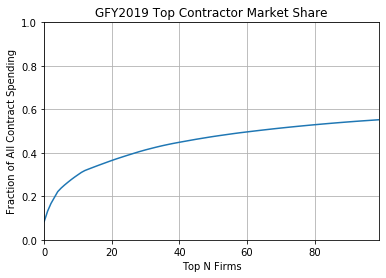

In [294]:
df_parent_recipient_obligations['Cumulative_Sum_Sorted'] = df_parent_recipient_obligations["Fraction_of_Total_Obligations"].cumsum()

display = df_parent_recipient_obligations.head(100)['Cumulative_Sum_Sorted'].plot(title = f"GFY{gfy} Top Contractor Market Share", grid=True)
display.set_ylim(0.0, 1.0)
#display.grid('on', which='minor', axis='both')
display.set_xlabel("Top N Firms")
display.set_ylabel("Fraction of All Contract Spending")

In [295]:
# df_subset is a Python pandas object which stores all of the data in RAM for fast access
# the ability to do this depends on the capacity of your computer
# if you have enough RAM, it is much faster to use a pandas object than Dask; however,
# Dask is great for organizing the whole collection of data so you can capture subsets

#### This next portion of code downloads a lookup table to get the names of the major product or services categories the USG uses

In [296]:
### Download the Federal Product or Service Code Lookup Spreadsheet for Reference Purposes

# retrieve the PSC Codes for reference and reporting purposes

def Get_PSC_Cat_Lookup_Descriptions():
    url_psc_lookup = 'https://www.acquisition.gov/sites/default/files/manual/PSC_Data_March_2020_Edition.xls' # latest version when coded - may have bene updated - see here https://www.acquisition.gov/psc-manual

    # download the file from the website to read into pandas
    r = requests.get(url_psc_lookup, allow_redirects=True)
    file_name = "Federal_PSC_Lookup_Codes.xlsx"
    with open(file_name, 'wb') as output:
      output.write(r.content)

    xls = pd.ExcelFile(file_name)
    df_psc_lookup = pd.read_excel(xls, sheet_name = 1, skiprows=0) #note that there are Excel Sheets for each of the Level 1 Cats with more details
    df_psc_lookup.head()
    df_PSC_Cat_Lookup = df_psc_lookup[df_psc_lookup['PSC CODE'].str.len() <= 2][['PSC CODE', 'PRODUCT AND SERVICE CODE NAME']].drop_duplicates()
    return df_PSC_Cat_Lookup

df_PSC_Cat_Lookup = Get_PSC_Cat_Lookup_Descriptions()
#df_PSC_Cat_Lookup[:10]

In [297]:
# two of the most commonly used families of PSC Codes for IT and professional services work
df_PSC_Cat_Lookup[df_PSC_Cat_Lookup['PSC CODE'].isin(['D','R'])]

,PSC CODE,PRODUCT AND SERVICE CODE NAME
2894,D,ADP AND TELECOMMUNICATIONS
4731,R,"SUPPORT SVCS (PROF, ADMIN, MGMT)"


### View Federal Spending by Major Product or Service Code for the GFY (Sorted = Descending)

In [298]:
#Spending by Major Product or Service Code Category

#!!! Using ddf here with delayed processing
#df_Obligations_by_PSC = ddf.groupby(['PSC_Cat'])['federal_action_obligation'].sum().reset_index().sort_values(by='federal_action_obligation', ascending=False)

df_Obligations_by_PSC = Create_Obligations_DF(df_subset, groupby_fields = ['PSC_Cat'])

assert df_subset['federal_action_obligation'].sum()/1e9 - df_Obligations_by_PSC['federal_action_obligation'].sum()  < 1.0 #make sure notihng was lost in groupby

#view_fields = ['action_date_fiscal_year','PSC_Cat', 'PRODUCT AND SERVICE CODE NAME', 'federal_action_obligation','Fraction_of_Total_Obligations','Fraction_of_Total_Obligations_POSITIVE_ONLY','Cumulative_Sum_Sorted']

df_Obligations_by_PSC = df_Obligations_by_PSC.merge(df_PSC_Cat_Lookup, left_on='PSC_Cat', right_on='PSC CODE') #[view_fields] # add labels

df_Obligations_by_PSC[:10] #top 10 for the most recent GFY in the Data

,PSC_Cat,action_date_fiscal_year,federal_action_obligation,Fraction_of_Total_Obligations,PSC CODE,PRODUCT AND SERVICE CODE NAME
0,R,2019,8.584117e+10,0.145603,R,"SUPPORT SVCS (PROF, ADMIN, MGMT)"
1,A,2019,4.794547e+10,0.081325,A,RESEARCH AND DEVELOPMENT
2,D,2019,4.410414e+10,0.074809,D,ADP AND TELECOMMUNICATIONS
3,M,2019,3.068127e+10,0.052041,M,OPERATION OF GOVT OWNED FACILITY
4,Y,2019,2.712000e+10,0.046001,Y,CONSTRUCT OF STRUCTURES/FACILITIES
5,J,2019,2.431974e+10,0.041251,J,"MAINT, REPAIR, REBUILD EQUIPMENT"
6,Q,2019,2.281229e+10,0.038694,Q,MEDICAL SERVICES
7,Z,2019,1.521679e+10,0.025811,Z,"MAINT, REPAIR, ALTER REAL PROPERTY"
8,S,2019,1.367217e+10,0.023191,S,UTILITIES AND HOUSEKEEPING
9,V,2019,1.210490e+10,0.020532,V,"TRANSPORT, TRAVEL, RELOCATION"


In [299]:
### View Federal Spending by Department of Independent Agency for the GFY (Sorted = Descending)

df_Top_Departments = Create_Obligations_DF(df_subset, groupby_fields = ['funding_agency_name'])
df_Top_Departments[:10] #top 10 for most recent GFY in data

,action_date_fiscal_year,funding_agency_name,federal_action_obligation,Fraction_of_Total_Obligations
0,2019,DEPARTMENT OF DEFENSE (DOD),3.908163e+11,0.662898
1,2019,DEPARTMENT OF VETERANS AFFAIRS (VA),2.864115e+10,0.048581
2,2019,DEPARTMENT OF ENERGY (DOE),2.824128e+10,0.047903
3,2019,DEPARTMENT OF HEALTH AND HUMAN SERVICES (HHS),2.656124e+10,0.045053
4,2019,DEPARTMENT OF HOMELAND SECURITY (DHS),1.914134e+10,0.032467
5,2019,NATIONAL AERONAUTICS AND SPACE ADMINISTRATION ...,1.768413e+10,0.029996
6,2019,DEPARTMENT OF STATE (DOS),9.480790e+09,0.016081
7,2019,DEPARTMENT OF JUSTICE (DOJ),8.158064e+09,0.013838
8,2019,DEPARTMENT OF AGRICULTURE (USDA),7.622312e+09,0.012929
9,2019,DEPARTMENT OF TRANSPORTATION (DOT),6.440218e+09,0.010924


Text(0, 0.5, 'Fraction of Federal Contracting Spending')

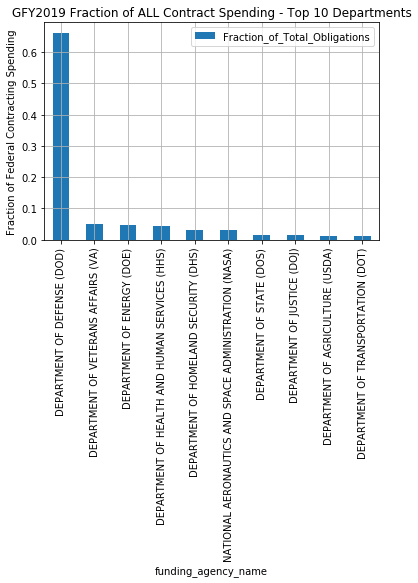

In [300]:
axis = df_Top_Departments[:10].plot.bar(x='funding_agency_name', y='Fraction_of_Total_Obligations', title=f'GFY{gfy} Fraction of ALL Contract Spending - Top 10 Departments', grid=True)
axis.set_ylabel("Fraction of Federal Contracting Spending")

### End of Medium Blog Post #4

### Begin Medium Blog Post #5

## Shift back to using Dask to sort through more than one GFY (slow initial operation)

### Let's Shift to Inspect of the HHS/Center for Medicare and Medicaid (CMS) Spending for the GFY

### Inspect CMS for all GFY in the variable df_GFY_obligations

In [365]:
%%time
# create a subset of the data for CMS only - Note: this data set is relatively small and will be loaded into pandas
# get the list of action_date_fiscal_year (s) included in the earlier variable df_GFY_obligations
gfy_available_dask = sorted(df_GFY_obligations['action_date_fiscal_year'].unique())
print(f"Retrieving CMS spending via Dask for these GFY and loading into pandas DataFrame: {gfy_available_dask}")

# you can alter what's in 

selector = (ddf['action_date_fiscal_year'].isin(gfy_available_dask)) & (ddf['funding_sub_agency_name'] == 'CENTERS FOR MEDICARE AND MEDICAID SERVICES')
df_CMS = ddf[selector].compute() # for Dask, you have to use .compute() to trigger the lazy computation

## Testing to confirm Enhance_Spending_File functions worked properly on convert from ddf Dask to pandas
assert 'recipient_name_common' in df_CMS.columns
assert 'PSC_Cat' in df_CMS.columns
assert df_CMS[df_CMS['recipient_parent_name_common']=='UNSPECIFIED'].groupby(['action_date_fiscal_year','recipient_name'])['federal_action_obligation'].sum().reset_index().shape[0] == 0

# next tests are unreliable since neither may be at CMS
assert df_CMS[df_CMS['recipient_parent_name'] == 'NORTHROP GRUMMAN SYSTEMS CORPORATION'].shape[0] == 0 # should be blank if functions at start on ddf load worked
assert df_CMS[df_CMS['recipient_parent_name'] == 'SCIENCE APPLICATIONS INTERNATIONAL CORPORATION'].shape[0] == 0 # should be blank if functions at start on ddf load worked

Retrieving CMS spending via Dask for these GFY and loading into pandas DataFrame: ['2017', '2018', '2019']
CPU times: user 21min 33s, sys: 1min 47s, total: 23min 21s
Wall time: 18min 41s


In [366]:
# How much memory (GB) does the CMS_only data subset use vs the GFY data?
print(f"CMS subset data memory use: {df_CMS.memory_usage().sum()/1e9} (GB)")
print("Obligation transactions per GFY:")
df_CMS.groupby(['action_date_fiscal_year'])['action_date_fiscal_year'].count()

CMS subset data memory use: 0.024342192 (GB)
Obligation transactions per GFY:


action_date_fiscal_year
2017    3473
2018    3302
2019    3827
Name: action_date_fiscal_year, dtype: int64

In [367]:
%%time
# perform a quick calculation to see total CMS spending in the GFY
df_CMS.groupby(['action_date_fiscal_year'])['federal_action_obligation'].sum().reset_index()

CPU times: user 3.67 ms, sys: 1.03 ms, total: 4.71 ms
Wall time: 3.51 ms


,action_date_fiscal_year,federal_action_obligation
0,2017,6.813959e+09
1,2018,6.752369e+09
2,2019,7.204226e+09


In [368]:
# What is the $ value of de-obligations?
df_CMS.query('federal_action_obligation < 0.0').groupby(['action_date_fiscal_year'])['federal_action_obligation'].sum().reset_index()

,action_date_fiscal_year,federal_action_obligation
0,2017,-1.438000e+08
1,2018,-1.634234e+08
2,2019,-1.893485e+08


In [369]:
### What types of work does CMS spend its contract dollars on?
### Show the Top 5 things per GFY

Create_Obligations_DF(df_CMS, groupby_fields = ['product_or_service_code', 'product_or_service_code_description']).groupby(['action_date_fiscal_year']).head(5).sort_values("action_date_fiscal_year", ascending=False)

,action_date_fiscal_year,product_or_service_code,product_or_service_code_description,federal_action_obligation,Fraction_of_Total_Obligations
0,2019,R499,SUPPORT- PROFESSIONAL: OTHER,2.316860e+09,0.321597
1,2019,D399,IT AND TELECOM- OTHER IT AND TELECOMMUNICATIONS,1.401149e+09,0.194490
2,2019,G007,SOCIAL- GOVERNMENT HEALTH INSURANCE PROGRAMS,1.066362e+09,0.148019
3,2019,Q101,MEDICAL- DEPENDENT MEDICARE,5.109286e+08,0.070921
4,2019,D306,IT AND TELECOM- SYSTEMS ANALYSIS,2.870975e+08,0.039851
122,2018,R499,SUPPORT- PROFESSIONAL: OTHER,2.094812e+09,0.310234
123,2018,D399,IT AND TELECOM- OTHER IT AND TELECOMMUNICATIONS,1.578511e+09,0.233771
124,2018,G007,SOCIAL- GOVERNMENT HEALTH INSURANCE PROGRAMS,1.119116e+09,0.165737
125,2018,D306,IT AND TELECOM- SYSTEMS ANALYSIS,2.628074e+08,0.038921
126,2018,7010,INFORMATION TECHNOLOGY EQUIPMENT SYSTEM CONFIG...,1.530463e+08,0.022666


In [370]:
### Show the Top N CMS Contractors per GFY?
top_N_contractors = 10
df_CMS_top_contractors_sorted = Create_Obligations_DF(df_CMS, groupby_fields = ['recipient_parent_name'])
most_recent_GFY = sorted(df_CMS_top_contractors_sorted['action_date_fiscal_year'].unique())[-1]
print(f"Top {top_N_contractors} contractors for most recent GFY: {most_recent_GFY}")
assert (1.0 - df_CMS_top_contractors_sorted.query("action_date_fiscal_year == @most_recent_GFY")['Fraction_of_Total_Obligations'].sum()) < 0.01
df_CMS_top_contractors_sorted.query("action_date_fiscal_year == @most_recent_GFY").groupby(['action_date_fiscal_year']).head(top_N_contractors)

Top 10 contractors for most recent GFY: 2019


,action_date_fiscal_year,recipient_parent_name_common,federal_action_obligation,Fraction_of_Total_Obligations
0,2019,GENERAL DYNAMICS CORPORATION,1.022924e+09,0.141989
1,2019,BLUE CROSS AND BLUE SHIELD OF SOUTH CAROLINA,4.112163e+08,0.057080
2,2019,LIVANTA LLC,2.812858e+08,0.039045
3,2019,WELLPOINT INC.,2.604205e+08,0.036148
4,2019,NORIDIAN MUTUAL INSURANCE COMPANY,2.369032e+08,0.032884
5,2019,LEIDOS HOLDINGS INC.,2.193119e+08,0.030442
6,2019,BLUE CROSS AND BLUE SHIELD OF FLORIDA INC.,2.011033e+08,0.027915
7,2019,SERCO GROUP PLC,1.988358e+08,0.027600
8,2019,KEYSTONE PEER REVIEW ORGANIZATION INC.,1.568191e+08,0.021768
9,2019,THE MITRE CORPORATION,1.471078e+08,0.020420


In [371]:
# An example of where the USAspending.gov system data has not been updated to reflect the acquisition by GDIT
# Press announcement on completition of acquisition 4/2/2018 - https://www.gd.com/Articles/2018/04/02/general-dynamics-completes-acquisition-csra
# GFY 2019 is ok but there is a partial overlap in GFY2018. Something to keep in mind for market analytics.
# note the remnants of references to SRA even after SRA merger and CSRA spinoff in 12/2015 - https://washingtonexec.com/2015/12/62668/#.X2yR8i9h2no
df_CMS_top_contractors_sorted[df_CMS_top_contractors_sorted['recipient_parent_name_common'].str.contains('SRA')]

,action_date_fiscal_year,recipient_parent_name_common,federal_action_obligation,Fraction_of_Total_Obligations
642,2018,SRA INTERNATIONAL INC.,2.585124e+07,0.003828
850,2018,CSRA LLC,7.610353e+05,0.000113
1127,2017,SRA INTERNATIONAL INC.,1.112052e+08,0.016320
1150,2017,CSRA LLC,3.922911e+07,0.005757


In [372]:
### How has the market share (Fraction_of_Total_Obligations) of the top CMS Contractor in the most recent GFY of the data changed over time?

top_contractor_name = df_CMS_top_contractors_sorted.iloc[0]['recipient_parent_name_common']
df_CMS_top_contractor_name = df_CMS_top_contractors_sorted[df_CMS_top_contractors_sorted['recipient_parent_name_common'] == top_contractor_name]
df_CMS_top_contractor_name

,action_date_fiscal_year,recipient_parent_name_common,federal_action_obligation,Fraction_of_Total_Obligations
0,2019,GENERAL DYNAMICS CORPORATION,1.022924e+09,0.141989
591,2018,GENERAL DYNAMICS CORPORATION,1.067382e+09,0.158075
1113,2017,GENERAL DYNAMICS CORPORATION,8.630788e+08,0.126663


In [373]:
# How has their CMS market-share changed after CSRA acquisition?

market_share_GFY2017 = float(df_CMS_top_contractor_name.query('action_date_fiscal_year == "2017"')['Fraction_of_Total_Obligations'].iloc[0])
market_share_GFY2019 = float(df_CMS_top_contractor_name.query('action_date_fiscal_year == "2019"')['Fraction_of_Total_Obligations'].iloc[0])
market_share_delta_basis_points = market_share_GFY2019 - market_share_GFY2017
round(market_share_delta_basis_points,4), round(market_share_delta_basis_points/market_share_GFY2017,4)

(0.0153, 0.121)

In [374]:
# (0.0077, 0.1852) => 1.5% increase of CMS Walletshare and 12.1% increase in annual prime obligations ('revenue')

(0.0, 0.17388265306047773)

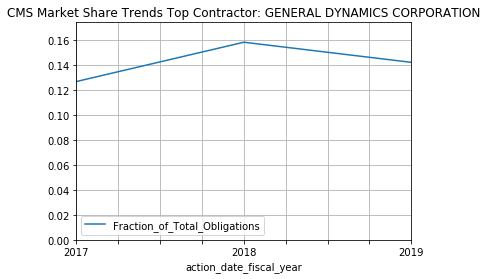

In [375]:
axis = df_CMS_top_contractor_name.sort_values(by='action_date_fiscal_year').plot(x='action_date_fiscal_year', y='Fraction_of_Total_Obligations', grid=True, title='CMS Market Share Trends Top Contractor: ' + top_contractor_name)
axis.set_ylim(0.0, df_CMS_top_contractor_name['Fraction_of_Total_Obligations'].max()*1.1)

In [376]:
### What is the advantage of being #1 at CMS vs #2 in terms of walletshare of CMS contractor spending?

CMS_number_1_walletshare = df_CMS_top_contractors_sorted.query("action_date_fiscal_year == @most_recent_GFY").iloc[0]['Fraction_of_Total_Obligations']
CMS_number_1_obligations = df_CMS_top_contractors_sorted.query("action_date_fiscal_year == @most_recent_GFY").iloc[0]['federal_action_obligation']

CMS_number_2_walletshare = df_CMS_top_contractors_sorted.query("action_date_fiscal_year == @most_recent_GFY").iloc[1]['Fraction_of_Total_Obligations']
CMS_number_2_obligations = df_CMS_top_contractors_sorted.query("action_date_fiscal_year == @most_recent_GFY").iloc[1]['federal_action_obligation']

round(CMS_number_1_walletshare/CMS_number_2_walletshare,2), int(CMS_number_1_obligations-CMS_number_2_obligations)

(2.49, 611707322)

In [377]:
# So, #1 $s/#2 $s is ~2.5 and that difference is worth ~612M/year in prime obligations.
# Every 1% increase in walletshare at CMS in GFY2019 => $208m/year in prime obligations

### Next: Explore Work by Keywords in award_description and major_program fields

In [378]:
### Search for obligations with the word 'fraud' in the award_description
### Show the top 5 contractors for each GFY

search_terms = ['fraud', 'program integrity']

df_CMS_fraud_work = df_CMS[df_CMS['award_description'].apply(lambda x: any(a_search_term.lower() in x.lower() for a_search_term in search_terms))]

df_CMS_fraud_work_contractors = Create_Obligations_DF(df_CMS_fraud_work, groupby_fields = ['recipient_parent_name'])
df_CMS_fraud_work_contractors.groupby(['action_date_fiscal_year']).head(5).sort_values("action_date_fiscal_year", ascending=False)

,action_date_fiscal_year,recipient_parent_name_common,federal_action_obligation,Fraction_of_Total_Obligations
0,2019,QUALITY HEALTH STRATEGIES INC.,58019013.00,0.293162
1,2019,GENERAL DYNAMICS CORPORATION,31117363.20,0.157232
2,2019,ADVANCEMED CORPORATION,28205285.72,0.142517
3,2019,NORTHROP GRUMMAN CORPORATION,24165406.00,0.122104
4,2019,HEWLETT PACKARD ENTERPRISE COMPANY,20417718.99,0.103168
23,2018,QUALITY HEALTH STRATEGIES INC.,35283972.00,0.202216
24,2018,ADVANCEMED CORPORATION,27840849.40,0.159559
25,2018,NORTHROP GRUMMAN CORPORATION,24519918.00,0.140526
26,2018,HEWLETT PACKARD ENTERPRISE COMPANY,19602535.93,0.112344
27,2018,GENERAL DYNAMICS CORPORATION,17736465.80,0.101650


#### Note that the Fraction_of_Total_Obligations here is in the context of obligations with the search terms

In [379]:
### For the top 10 CMS Contractors doing Fraud/Program Integrity Work, where else are they doing similar work across all of Federal?
last_full_GFY = str(CurrentGFY() - 1) # 'action_date_fiscal_year' is stored as a pandas/Dask 'object' and not int (add an assert check)

cms_top_10_fraud_contractors_last_full_GFY = sorted(df_CMS_fraud_work_contractors.query('action_date_fiscal_year == @last_full_GFY')[:10]['recipient_parent_name_common'])
cms_top_10_fraud_contractors_last_full_GFY

['A. REDDIX & ASSOCIATES INC.',
 'ADVANCEMED CORPORATION',
 'DANIEL J. EDELMAN  INC.',
 'DELOITTE LLP',
 'FU ASSOCIATES LIMITED',
 'GENERAL DYNAMICS CORPORATION',
 'HEWLETT PACKARD ENTERPRISE COMPANY',
 'INNOVISS  INC.',
 'NORTHROP GRUMMAN CORPORATION',
 'QUALITY HEALTH STRATEGIES  INC.']

In [380]:
%%time
###!!! this is a time consuming operation to scan through all files in the Dask ddf CSV files
### Collect the subset of GFY obligations for these CMS Top 10 Fraud/Program Integrity Contractors

df_Contractor_Subset_Explore = ddf[ddf['recipient_parent_name_common'].isin(cms_top_10_fraud_contractors_last_full_GFY)].compute() #Dask task - slow - must read all the source CSV files

CPU times: user 22min 18s, sys: 1min 46s, total: 24min 5s
Wall time: 19min 21s


In [381]:
### Size of those contractors in GFY Across All Federal Work in USASpending.gov

Create_Obligations_DF(df_Contractor_Subset_Explore, groupby_fields = ['recipient_parent_name'])

,action_date_fiscal_year,recipient_parent_name_common,federal_action_obligation,Fraction_of_Total_Obligations
0,2019,GENERAL DYNAMICS CORPORATION,2.091691e+10,0.530627
1,2019,NORTHROP GRUMMAN CORPORATION,1.599633e+10,0.405800
2,2019,DELOITTE LLP,2.214118e+09,0.056168
3,2019,HEWLETT PACKARD ENTERPRISE COMPANY,1.603457e+08,0.004068
4,2019,QUALITY HEALTH STRATEGIES INC.,5.802442e+07,0.001472
5,2019,ADVANCEMED CORPORATION,2.885817e+07,0.000732
6,2019,DANIEL J. EDELMAN INC.,1.317806e+07,0.000334
7,2019,A. REDDIX & ASSOCIATES INC.,1.227905e+07,0.000311
8,2019,INNOVISS INC.,1.072640e+07,0.000272
9,2019,FU ASSOCIATES LIMITED,8.468736e+06,0.000215


In [382]:
# Where are those same contractors doing work with the same terms in the award field in all agencies
search_terms = ['fraud', 'program integrity']

df_Contractor_Subset_Explore_fraud_work = df_Contractor_Subset_Explore[df_Contractor_Subset_Explore['award_description'].apply(lambda x: any(a_search_term.lower() in x.lower() for a_search_term in search_terms))]

#Create_Obligations_DF(df_Contractor_Subset_Explore_fraud_work, groupby_fields = ['recipient_parent_name'])

Create_Obligations_DF(df_Contractor_Subset_Explore_fraud_work, groupby_fields = ['recipient_parent_name','funding_agency_name','funding_sub_agency_name'])

,action_date_fiscal_year,funding_agency_name,funding_sub_agency_name,recipient_parent_name_common,federal_action_obligation,Fraction_of_Total_Obligations
0,2019,DEPARTMENT OF HEALTH AND HUMAN SERVICES (HHS),CENTERS FOR MEDICARE AND MEDICAID SERVICES,QUALITY HEALTH STRATEGIES INC.,58019013.00,3.058820e-01
1,2019,DEPARTMENT OF HEALTH AND HUMAN SERVICES (HHS),CENTERS FOR MEDICARE AND MEDICAID SERVICES,GENERAL DYNAMICS CORPORATION,31117363.20,1.640538e-01
2,2019,DEPARTMENT OF HEALTH AND HUMAN SERVICES (HHS),CENTERS FOR MEDICARE AND MEDICAID SERVICES,ADVANCEMED CORPORATION,28205285.72,1.487010e-01
3,2019,DEPARTMENT OF HEALTH AND HUMAN SERVICES (HHS),CENTERS FOR MEDICARE AND MEDICAID SERVICES,NORTHROP GRUMMAN CORPORATION,24165406.00,1.274024e-01
4,2019,DEPARTMENT OF HEALTH AND HUMAN SERVICES (HHS),CENTERS FOR MEDICARE AND MEDICAID SERVICES,HEWLETT PACKARD ENTERPRISE COMPANY,20417718.99,1.076442e-01
5,2019,DEPARTMENT OF HEALTH AND HUMAN SERVICES (HHS),CENTERS FOR MEDICARE AND MEDICAID SERVICES,DELOITTE LLP,9706963.00,5.117607e-02
6,2019,DEPARTMENT OF HEALTH AND HUMAN SERVICES (HHS),CENTERS FOR MEDICARE AND MEDICAID SERVICES,DANIEL J. EDELMAN INC.,6998571.00,3.689716e-02
7,2019,DEPARTMENT OF HEALTH AND HUMAN SERVICES (HHS),CENTERS FOR MEDICARE AND MEDICAID SERVICES,INNOVISS INC.,3930929.00,2.072425e-02
8,2019,DEPARTMENT OF HEALTH AND HUMAN SERVICES (HHS),CENTERS FOR MEDICARE AND MEDICAID SERVICES,A. REDDIX & ASSOCIATES INC.,3835197.00,2.021954e-02
9,2019,DEPARTMENT OF HEALTH AND HUMAN SERVICES (HHS),CENTERS FOR MEDICARE AND MEDICAID SERVICES,FU ASSOCIATES LIMITED,3205975.00,1.690222e-02


In [383]:
%%time
### Where else is does work with the Search Terms show up in the Federal Market?

search_terms = ['fraud', 'program integrity']

LAMBDA_search_term = lambda x: any(a_search_term.lower() in x.lower() for a_search_term in search_terms)
meta = ('award_description', 'str') # needed for Dask but not for pandas
ddf_Contractor_Explore_fraud_work = ddf[ddf['award_description'].apply(LAMBDA_search_term, meta=meta)].compute()

df_Search_Terms_ALL_Federal = Create_Obligations_DF(ddf_Contractor_Explore_fraud_work, groupby_fields = ['funding_agency_name','funding_sub_agency_name'])
df_Search_Terms_ALL_Federal

CPU times: user 22min 25s, sys: 1min 49s, total: 24min 15s
Wall time: 19min 34s


,action_date_fiscal_year,funding_agency_name,funding_sub_agency_name,federal_action_obligation,Fraction_of_Total_Obligations
0,2019,DEPARTMENT OF HEALTH AND HUMAN SERVICES (HHS),CENTERS FOR MEDICARE AND MEDICAID SERVICES,1.979077e+08,0.868868
1,2019,DEPARTMENT OF HOMELAND SECURITY (DHS),U.S. CITIZENSHIP AND IMMIGRATION SERVICES,8.268353e+06,0.036300
2,2019,SOCIAL SECURITY ADMINISTRATION (SSA),SOCIAL SECURITY ADMINISTRATION,5.310571e+06,0.023315
3,2019,DEPARTMENT OF STATE (DOS),"STATE, DEPARTMENT OF",5.068944e+06,0.022254
4,2019,DEPARTMENT OF AGRICULTURE (USDA),FOOD AND NUTRITION SERVICE,3.313846e+06,0.014549
5,2019,DEPARTMENT OF HOUSING AND URBAN DEVELOPMENT (HUD),"HOUSING AND URBAN DEVELOPMENT, DEPARTMENT OF",3.016512e+06,0.013243
6,2019,DEPARTMENT OF JUSTICE (DOJ),"OFFICES, BOARDS AND DIVISIONS",2.354720e+06,0.010338
7,2019,ENVIRONMENTAL PROTECTION AGENCY (EPA),ENVIRONMENTAL PROTECTION AGENCY,1.506715e+06,0.006615
8,2019,DEPARTMENT OF HEALTH AND HUMAN SERVICES (HHS),OFFICE OF THE ASSISTANT SECRETARY FOR ADMINIST...,8.325240e+05,0.003655
9,2019,AGENCY FOR INTERNATIONAL DEVELOPMENT (USAID),AGENCY FOR INTERNATIONAL DEVELOPMENT,2.764760e+05,0.001214


In [384]:
### When does the majority of this work end for the contractors (after NOW)?

ddf_Contractor_Explore_fraud_work_End_Dates = ddf_Contractor_Explore_fraud_work.query('federal_action_obligation > 0.0').groupby(['recipient_parent_name','period_of_performance_potential_end_date', 'parent_award_id_piid', 'award_id_piid'])['federal_action_obligation'].sum().reset_index()
ddf_Contractor_Explore_fraud_work_End_Dates = ddf_Contractor_Explore_fraud_work_End_Dates[ddf_Contractor_Explore_fraud_work_End_Dates['period_of_performance_potential_end_date'] != 'UNSPECIFIED']
ddf_Contractor_Explore_fraud_work_End_Dates['period_of_performance_potential_end_date'] = ddf_Contractor_Explore_fraud_work_End_Dates['period_of_performance_potential_end_date'].astype('datetime64[ns]')

# find those obligations $'s > $5M and expiring after today
selector = (ddf_Contractor_Explore_fraud_work_End_Dates['federal_action_obligation'] > 5e6) & (ddf_Contractor_Explore_fraud_work_End_Dates['period_of_performance_potential_end_date'] > datetime.now())
ddf_Contractor_Explore_fraud_work_End_Dates[selector].sort_values(by='period_of_performance_potential_end_date')

,recipient_parent_name,period_of_performance_potential_end_date,parent_award_id_piid,award_id_piid,federal_action_obligation
216,NORTHROP GRUMMAN CORPORATION,2021-03-31,UNSPECIFIED,HHSM500201600023C,74150509.00
12,ADVANCEMED CORPORATION,2021-07-18,HHSM500201600079I,HHSM500T0001,50266878.12
207,NCI INC.,2021-07-18,HHSM500201600079I,HHSM500T0001,21814340.07
7,ACUITY INC.,2021-09-26,GS35F0560W,70SBUR18F00000657,17251100.76
119,HEWLETT PACKARD ENTERPRISE COMPANY,2021-10-31,HHSM500201600083I,HHSM500T0001,52241177.40
93,EXCELLA CONSULTING INC.,2021-12-05,GS35F0115R,70SBUR18F00000697,14442615.57
112,GEOCENT L.L.C.,2022-01-09,GS35F0027M,70SBUR19F00000062,17895489.54
245,QUALITY HEALTH STRATEGIES INC.,2022-02-15,HHSM500201600080I,HHSM500T0001,14354577.00
246,QUALITY HEALTH STRATEGIES INC.,2022-09-14,HHSM500201600080I,HHSM500T0002,14127173.00
251,RELX INC.,2022-09-17,LC14C7121,SAQMMA17F2678,8036340.00


In [385]:
## You can export the list to a CSV file for analysis in Google Sheets or Excel
ddf_Contractor_Explore_fraud_work_End_Dates.to_csv("Contractor_Explore_fraud_work_End_Dates.csv", index=False)

In [386]:
### IN GFY 2019, HHS CMS Accounts for ~86% of Annual Spending where the award description includes 'fraud' and/or 'program integrity'. If our fictional commercial insurance company with the fraud detection and prevention software solutions wants to sell to the Federal Government, they will need to concentrate their efforts on CMS.

In [387]:
%%time
### How might this process work if the company is interested in where AI ('Artificial Intelligence') Work is the Focus on the award_description

search_terms = ['artificial-intelligence', 
                'artificial intelligence', 
                'deep learning',
                'deep-learning',
                'machine learning',
                'machine-learning',
                'data science', 
                'analytics',
                'predictive analytics',
                'predictive-analytics',
                'big data',
                'big-data',
                'business intelligence',
               ] #AI related
LAMBDA_search_term = lambda x: any(a_search_term.lower() in x.lower() for a_search_term in search_terms)
meta = ('award_description', 'str') # needed for Dask but not for pandas
ddf_Contractor_Explore_AI = ddf[ddf['award_description'].apply(LAMBDA_search_term, meta=meta)].compute() # Dask task so must add .compute()

df_Explore_AI_ALL_GFY_available = Create_Obligations_DF(ddf_Contractor_Explore_AI, groupby_fields = ['funding_agency_name','funding_sub_agency_name'])
df_Explore_AI_ALL_GFY_available

CPU times: user 22min 55s, sys: 1min 52s, total: 24min 47s
Wall time: 20min 7s


,action_date_fiscal_year,funding_agency_name,funding_sub_agency_name,federal_action_obligation,Fraction_of_Total_Obligations
0,2019,DEPARTMENT OF HEALTH AND HUMAN SERVICES (HHS),CENTERS FOR MEDICARE AND MEDICAID SERVICES,1.023002e+08,1.083406e-01
1,2019,DEPARTMENT OF DEFENSE (DOD),DEPT OF THE NAVY,9.477313e+07,1.003691e-01
2,2019,DEPARTMENT OF DEFENSE (DOD),DEPT OF DEFENSE,7.757853e+07,8.215922e-02
3,2019,DEPARTMENT OF DEFENSE (DOD),DEPT OF THE ARMY,6.203080e+07,6.569346e-02
4,2019,DEPARTMENT OF DEFENSE (DOD),DEPT OF THE AIR FORCE,5.162799e+07,5.467641e-02
5,2019,DEPARTMENT OF VETERANS AFFAIRS (VA),"VETERANS AFFAIRS, DEPARTMENT OF",5.000216e+07,5.295458e-02
6,2019,DEPARTMENT OF THE TREASURY (TREAS),INTERNAL REVENUE SERVICE,4.359097e+07,4.616483e-02
7,2019,DEPARTMENT OF DEFENSE (DOD),DEFENSE ADVANCED RESEARCH PROJECTS AGENCY (DA...,3.669990e+07,3.886687e-02
8,2019,DEPARTMENT OF HOMELAND SECURITY (DHS),U.S. CITIZENSHIP AND IMMIGRATION SERVICES,3.199955e+07,3.388899e-02
9,2019,DEPARTMENT OF DEFENSE (DOD),DEFENSE HEALTH AGENCY (DHA),3.005565e+07,3.183031e-02


In [388]:
df_Explore_AI_ALL_GFY_available.groupby(['action_date_fiscal_year'])['federal_action_obligation'].sum().reset_index()

,action_date_fiscal_year,federal_action_obligation
0,2017,6.017357e+08
1,2018,7.842741e+08
2,2019,9.442462e+08


Text(0, 0.5, "$'s in M")

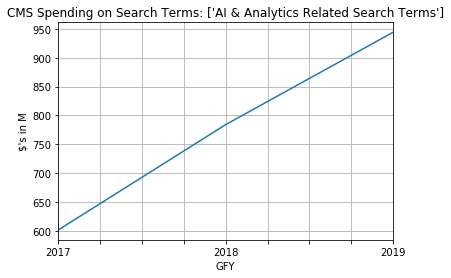

In [389]:
search_terms_unique = ['AI & Analytics Related Search Terms']
df_search_term_total_spending = df_Explore_AI_ALL_GFY_available.groupby(['action_date_fiscal_year'])['federal_action_obligation'].sum()/1e6
axis = df_search_term_total_spending.plot(grid=True, title="CMS Spending on Search Terms: " + str(search_terms_unique))
axis.set_xlabel("GFY")
axis.set_ylabel("$'s in M")

In [390]:
### Let's focus on CMS Again and see which AI search terms and which contractors are doing the work

search_terms = ['artificial-intelligence', 
                'artificial intelligence', 
                'deep learning',
                'deep-learning',
                'machine learning',
                'machine-learning',
                'data science', 
                'analytics',
                'predictive analytics',
                'predictive-analytics',
                'big data',
                'big-data',
                'business intelligence',
               ] #AI related

aTerm = search_terms[0]
print(aTerm)
df_CMS_AI_Work = df_CMS[df_CMS['award_description'].apply(lambda x: True if aTerm in x.lower() else False)].copy()
df_CMS_AI_Work['search_term'] = aTerm

for aTerm in search_terms[1:]:
    print(aTerm)
    df_temp = df_CMS[df_CMS['award_description'].apply(lambda x: True if aTerm in x.lower() else False)].copy()
    df_temp['search_term'] = aTerm
    df_CMS_AI_Work = df_CMS_AI_Work.append(df_temp)

df_CMS_AI_Work_no_duplicates = df_CMS_AI_Work.groupby(['action_date_fiscal_year', 'contract_transaction_unique_key', 'recipient_parent_name','federal_action_obligation'])['search_term'].apply(lambda x: list(set(x))).apply(lambda x: "+".join(x)).reset_index().drop_duplicates('contract_transaction_unique_key')

df_Obligations_by_Term = df_CMS_AI_Work_no_duplicates.groupby(['action_date_fiscal_year','search_term'])['federal_action_obligation'].sum().reset_index()
df_Obligations_by_Term

artificial-intelligence
artificial intelligence
deep learning
deep-learning
machine learning
machine-learning
data science
analytics
predictive analytics
predictive-analytics
big data
big-data
business intelligence


,action_date_fiscal_year,search_term,federal_action_obligation
0,2017,analytics,74623832.36
1,2018,analytics,93635656.01
2,2018,business intelligence+analytics,7703984.42
3,2019,analytics,90706084.67
4,2019,business intelligence+analytics,11594097.07


Text(0, 0.5, "$'s in M")

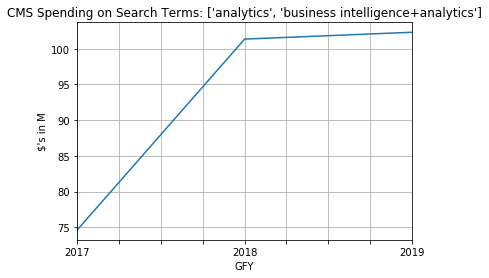

In [391]:
search_terms_unique = sorted(df_Obligations_by_Term['search_term'].unique())
df_search_term_total_spending = df_Obligations_by_Term.groupby(['action_date_fiscal_year'])['federal_action_obligation'].sum()/1e6
axis = df_search_term_total_spending.plot(grid=True, title="CMS Spending on Search Terms: " + str(search_terms_unique))
axis.set_xlabel("GFY")
axis.set_ylabel("$'s in M")

In [392]:
### Which are the top contractors at CMS for work using the search terms?

df_Contractors_Total = Create_Obligations_DF(df_CMS_AI_Work_no_duplicates, groupby_fields = ['recipient_parent_name'])
df_Contractors_Total[:10] # Top 10 in most recent GFY of data

Warning [in function Create_Obligations_DF]: In computing groupby recipient_name and recipient_parent_name is missing 'recipient_parent_name' column
...groupby totals by recipient_parent_name and recipient_name may be incomplete.
...Recommend running function Add_Common_Recipient_Names on DataFrame prior to using this function.


,action_date_fiscal_year,recipient_parent_name,federal_action_obligation,Fraction_of_Total_Obligations
0,2019,MATHEMATICA INC.,19147507.00,0.187170
1,2019,SEMANTICBITS LLC,13138036.00,0.128426
2,2019,LOGISTICS MANAGEMENT INSTITUTE,13029047.00,0.127361
3,2019,SPARKSOFT CORPORATION,12288887.00,0.120126
4,2019,OPERA SOLUTIONS OPCO LLC,11999472.00,0.117297
5,2019,APPRIO INC,11594097.07,0.113334
6,2019,CACI INTERNATIONAL INC,5360256.48,0.052397
7,2019,RELI GROUP INC,3999204.33,0.039093
8,2019,INDEX ANALYTICS LLC,3996676.02,0.039068
9,2019,REVEAL GLOBAL CONSULTING LLC,3166781.04,0.030956


In [393]:
#Test to confirm no duplicate transactions 
assert df_Obligations_by_Term['federal_action_obligation'].sum() == df_Contractors_Total['federal_action_obligation'].sum()

### Finally, close out Dask cluster processes

In [330]:
# close down the dask processes and gracefully exit
#client.close() 
Close_Dask_Client_Robust()

https://opensource.org/licenses/MIT

MIT Open Source License Copyright 2020 Leif C Ulstrup

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.